# Understanding Attention

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch08_Attention/ec08_1_attention/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
# !pip install contractions deeplay spacy  # Uncomment if using Colab/Kaggle.

This notebook provides a complete code example that demonstrates how the attention mechanism works.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 8-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Obtaining a Matrix Representation of Sentences

Start by writing two sentences ...

In [2]:
query_sentence = "The teacher praised a student because she improved"
key_sentence = "A student asked the teacher to help her improving"

... tokenize the two sentences ...

In [3]:
query_tokens = query_sentence.split()
key_tokens = key_sentence.split()

... print the tokens ...

In [4]:
print(query_tokens)
print(key_tokens)

['The', 'teacher', 'praised', 'a', 'student', 'because', 'she', 'improved']
['A', 'student', 'asked', 'the', 'teacher', 'to', 'help', 'her', 'improving']


... download the GloVe embeddings ...

In [5]:
import os
from torchvision.datasets.utils import download_url, extract_archive

glove_folder = ".glove_cache"
if not os.path.exists(glove_folder):
    os.makedirs(glove_folder, exist_ok=True)
    url = "https://nlp.stanford.edu/data/glove.42B.300d.zip"
    download_url(url, glove_folder)
    zip_filepath = os.path.join(glove_folder, "glove.42B.300d.zip")
    extract_archive(zip_filepath, glove_folder)
    os.remove(zip_filepath)

... implement a function to load the GloVe embeddings ...

In [6]:
def load_glove_embeddings(glove_file):
    """Load GloVe embeddings."""
    glove_embeddings = {}
    with open(glove_file, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            glove_embeddings[word] = np.round(
                np.asarray(values[1:], dtype="float32"), decimals=6,
            )
    return glove_embeddings

... implement a function to get GloVe embeddings for a vocabulary ...

In [7]:
def get_glove_embeddings(vocab, glove_embeddings, embed_dim):
    """Get GloVe embeddings for a vocabulary."""
    embeddings = torch.zeros((len(vocab), embed_dim), dtype=torch.float32)
    for i, token in enumerate(vocab):
        embedding = glove_embeddings.get(token)
        if embedding is None:
            embedding = glove_embeddings.get(token.lower())
        if embedding is not None:
            embeddings[i] = torch.tensor(embedding, dtype=torch.float32)
    return embeddings

... calculate the embeddings of the query and key sentences ...

In [8]:
import numpy as np
import torch

glove_file = os.path.join(glove_folder, "glove.42B.300d.txt")
glove_embed, embed_dim = load_glove_embeddings(glove_file), 300

query_embeddings = get_glove_embeddings(query_tokens, glove_embed, embed_dim)
key_embeddings = get_glove_embeddings(key_tokens, glove_embed, embed_dim)

... and print them out.

In [9]:
print(query_embeddings)
print(key_embeddings)

tensor([[-0.2084, -0.1493, -0.0175,  ..., -0.5407,  0.2120, -0.0094],
        [ 0.3659,  0.1827, -0.2922,  ...,  0.1551,  0.4864,  0.3274],
        [ 0.1378,  0.4019,  0.0804,  ...,  0.1261,  0.5996,  0.5268],
        ...,
        [ 0.1013, -0.1351, -0.2975,  ...,  0.0224,  0.2362,  0.1049],
        [-0.0079,  0.4521, -0.3142,  ..., -0.1546,  0.3127,  0.2481],
        [-0.0133,  0.0232,  0.1770,  ...,  0.0170,  0.2138,  0.1573]])
tensor([[-0.0358,  0.7784, -0.5181,  ...,  0.0223, -0.3159, -0.3561],
        [ 0.3523, -0.0145, -0.2560,  ...,  0.1641,  0.3485, -0.1979],
        [-0.1269, -0.4053, -0.1072,  ...,  0.1691,  0.6001, -0.1345],
        ...,
        [-0.0088,  0.4015,  0.2687,  ...,  0.2388,  0.3528, -0.2538],
        [-0.0932,  0.2168, -0.5035,  ..., -0.3581, -0.1630,  0.5610],
        [-0.0948,  0.0913, -0.0308,  ..., -0.0845,  0.3207,  0.1550]])


## Implementing Dot-Product Attention

Implement a class to perform the dot-product attention ...

In [10]:
import deeplay as dl

class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""

    def __init__(self):
        """Initialize dot-product attention."""
        super().__init__()

    def forward(self, queries, keys, values):
        """Calculate dot-product attention."""
        attn_scores = (torch.matmul(queries, keys.transpose(-2, -1))
                       / (keys.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix

... calculate attention matrix and attention output ...

In [11]:
attention = DotProductAttention()
attn_output, attn_matrix = attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)

... implement a function to plot an attention matrix ...

In [12]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator

def plot_attention(query_tokens, key_tokens, attn_matrix):
    """Plot attention."""
    fig, ax = plt.subplots()
    cax = ax.matshow(attn_matrix, cmap="Greens")
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(FixedLocator(range(len(key_tokens))))
    ax.yaxis.set_major_locator(FixedLocator(range(len(query_tokens))))
    ax.set_xticklabels(key_tokens, rotation=90)
    ax.set_yticklabels(query_tokens)
    plt.show()

... and use it to plot the attention matrix.

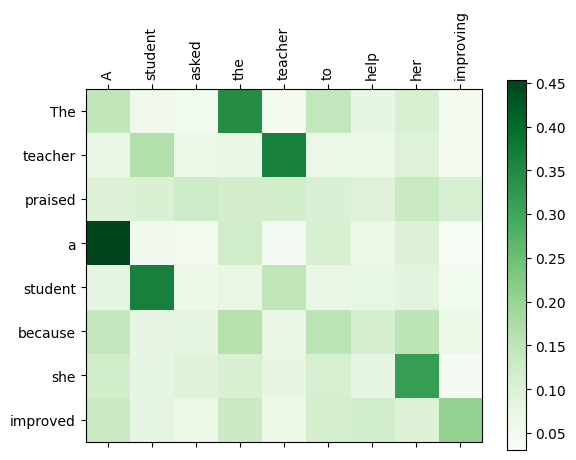

In [13]:
plot_attention(query_tokens, key_tokens, attn_matrix.detach().squeeze())

## Making the Attention Mechanism Trainable

Implement a class to perform a trainable dot-product attention ...

In [14]:
class TrainableAttention(dl.DeeplayModule):
    """Trainable dot-product attention."""

    def __init__(self, num_in_features=300, num_out_features=256):
        """Initialize dot-product attention."""
        super().__init__()
        self.Wq = torch.nn.Linear(num_in_features, num_out_features)
        self.Wk = torch.nn.Linear(num_in_features, num_out_features)
        self.Wv = torch.nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        """Calculate dot-product attention with linear transformations."""
        Q, K, V = self.Wq(queries), self.Wk(keys), self.Wv(values)
        attn_scores = (torch.matmul(Q, K.transpose(-2, -1))
                       / (K.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, V)
        return attn_output, attn_matrix

... calculate it ...

In [15]:
trainable_attention = TrainableAttention()
trainable_attn_output, trainable_attn_matrix = trainable_attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)

... and plot the resulting attention matrix.

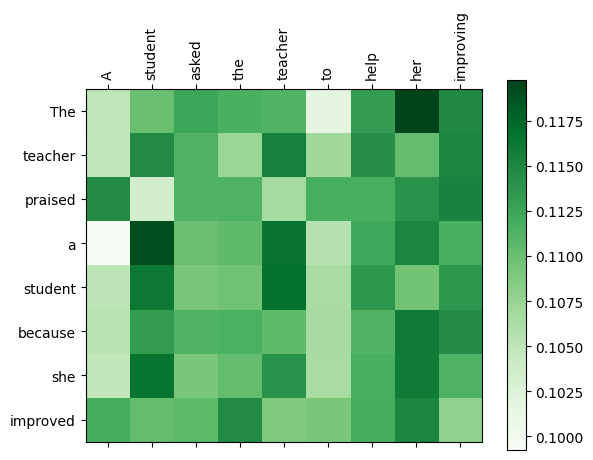

In [16]:
plot_attention(query_tokens, key_tokens,
               trainable_attn_matrix.detach().squeeze())

## Implementing Additive Attention

Implement a class to perform additive attention ...

In [17]:
class AdditiveAttention(dl.DeeplayModule):
    """Additive attention."""

    def __init__(self, num_in_features=300, num_out_features=256):
        """Initialize additive attention."""
        super().__init__()
        self.Wq = torch.nn.Linear(num_in_features, num_out_features)
        self.Wk = torch.nn.Linear(num_in_features, num_out_features)
        self.Ws = torch.nn.Linear(num_out_features, 1)

    def forward(self, queries, keys, values):
        """Calculate additive attention."""
        Q, K = self.Wq(queries), self.Wk(keys)
        attn_scores = self.Ws(
            torch.tanh(Q.unsqueeze(-2) + K.unsqueeze(-3))
        ).transpose(-2, -1)
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix

... calculate it ...

In [18]:
additive_attention = AdditiveAttention()
additive_attn_output, additive_attn_matrix = additive_attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)

... and plot the resulting attention matrix.

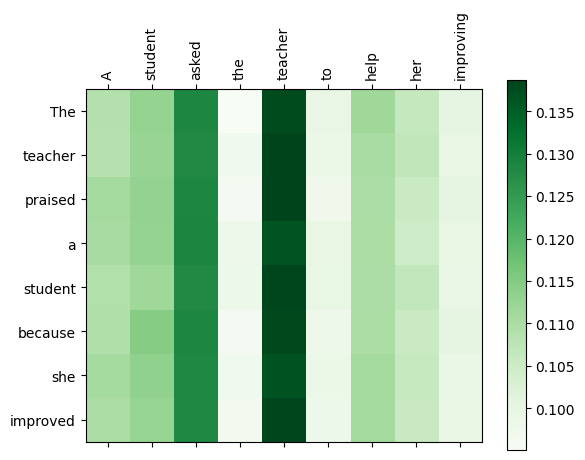

In [19]:
plot_attention(query_tokens, key_tokens, 
               additive_attn_matrix.detach().squeeze())